In [1]:
# python
import os
from itertools import combinations, product

# stats
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.api import OLS

# plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# analysis code
from lib.functions_second_analysis import *
from lib.functions_scripting import *


beauty_ratings = load_ratings(PATH_RATINGS)

In [2]:
_models = MODEL_NAMES
_studies = STUDY_NAMES
_datasets = DATASET_NAMES
_scales = SCALE_NAMES

In [ ]:
_models = MODEL_NAMES
_studies = "short presentation"
_datasets = "places1"
_scales = "scale4"

In [ ]:
_models = NETS_ALL
_studies = STUDY_NAMES
_datasets = DATASET_NAMES
_scales = SCALE_NAMES

In [ ]:
# subselect models that have significant predictions at scale4
models_to_remove = set(
    ["edge_occlusion", "inpainting", "keypoints", "normal", "jigsaw"]
)
_models = list(set(MODEL_NAMES).difference(models_to_remove))

In [3]:
# no subselections
dfi = load_integration(PATH_INTEGRATION)
dfibc = load_ibcorr(PATH_IBCORR)

In [11]:
# unblocked data
_blocking = "unblocked"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION)
dfibc = load_ibcorr(PATH_IBCORR)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

In [ ]:
# averaged data
_blocking = "average"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION_AVERAGE)
dfibc = load_ibcorr(PATH_IBCORR_AVERAGE)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

In [ ]:
# maxpooled data
_blocking = "maxpool"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION_MAXPOOL)
dfibc = load_ibcorr(PATH_IBCORR_MAXPOOL)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

Integration profile between layers

RDM of RDM's that correlate integration ratings of each different layers inside each network.


TODO: Is this essentially the same thing as absoloute correlation differences alone ?
copy code for each models layerXlayer RDM
correlate correlations using daniels code

# layerxlayer structure 

## all layers

In [ ]:
layerlayer_integration_rdms = (
    dfi.unstack("layer").groupby(["dataset", "scale", "model"]).apply(calculate_rdm)
)

In [12]:
layerlayer_integration_rdms.to_hdf(
    os.path.join(
        PATH_RESULTS,
        "layer profile",
        "layerxlayer integration rdms",
        "allnets " + _blocking + ".h5",
    ),
    key="layerlayer_integration_rdms",
)

In [ ]:
layerlayer_integration_rdms = pd.read_hdf(
    os.path.join(
        PATH_RESULTS,
        "layer profile",
        "layerxlayer integration rdms",
        "allnets " + _blocking + ".h5",
    ),
    key="layerlayer_integration_rdms",
)

### plot

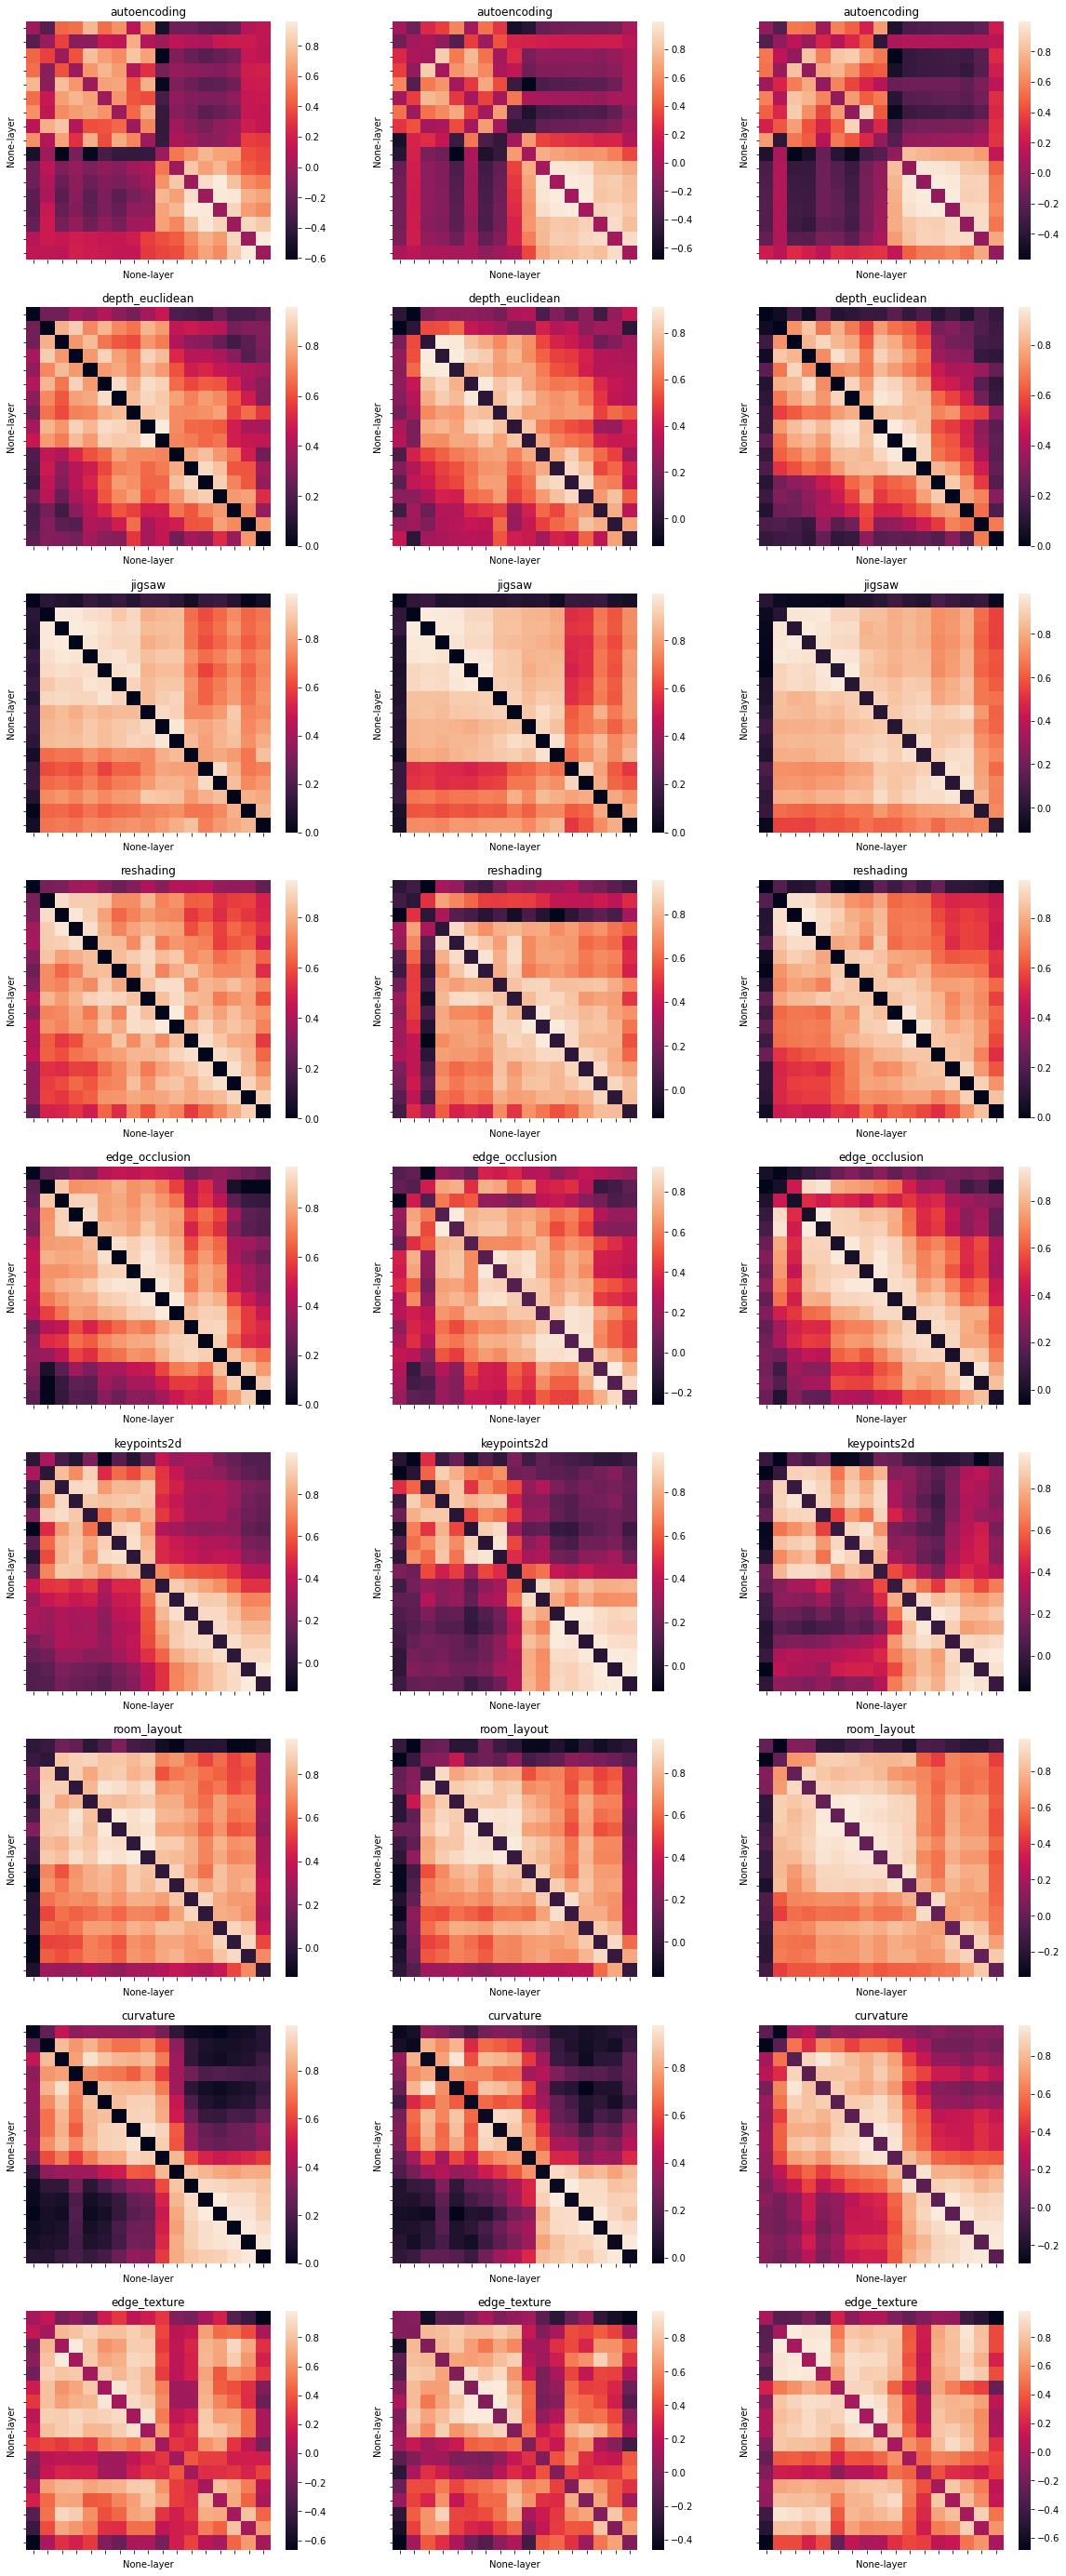

In [ ]:
fig, axes = plt.subplots(9,3, figsize=(20,50))

for (mo, da), ax in zip(product(MODEL_NAMES[:10], DATASET_NAMES), axes.flat):
    #ax.plot(tmp.loc[(da, "scale4", mo)])
    ax.set_title(mo)
    sns.heatmap(factor2_rdms.loc[(da, "scale4", mo)], ax=ax)
    ax.set_xticklabels("")
    ax.set_yticklabels("")

## best predicting layer

ordering of images by integration in best predicting layer

"what is integrated", alternatively average of correlation between in each layer, howevery layers may not correspond to each other, therefore best predicting layer is more general <br> <br>

Interpretation: The differences in absolout values correspond to how similar the "integration mechanism" in both networks are.<br> If we assume that beauty perception depends on a specific stage of processing and not the whole processing stream, then the best predicting layer of a network can be interpreted as the point, where the network best mimics the aspects of the processing that determine beauty. <br> 

If the a similar The value in Is there a single or are there different ways of predicting beauty ?`

In [ ]:
bestlayers = (
    dfibc.groupby(["study", "scale", "model"])
    .idxmax()
    .ibcorr.transform(lambda idx: idx[-1])
    .to_frame()
    .reset_index()
    .values.tolist()
)

In [ ]:
dfi2 = dfi.reorder_levels(("dataset","scale","model","layer", "img"))

dfi2.index = dfi2.index.set_names(level="dataset", names="study").set_levels(
    dfi2.index.levels[0].map(
        {
            "places1": "short presentation",
            "places2": "complexity order",
            "oasis": "oasis",
        }
    ),level="study"
)

dfi2_longpresentation = (
    dfi2.loc["short presentation"]
    .assign(study="long presentation")
    .set_index("study", append=True)
    .reorder_levels(("study", "scale", "model", "layer", "img"))
)
dfi_studies = pd.concat((dfi2, dfi2_longpresentation))

In [ ]:
df_best_integration = (
    dfi_studies.unstack("img").loc[bestlayers].droplevel("layer").stack("img")
)

In [ ]:
factor2_rdm_bestlayer = (
    df_best_integration.unstack("model")
    .groupby(["study", "scale"])
    .apply(calculate_rdm)
)

# predictorRDM

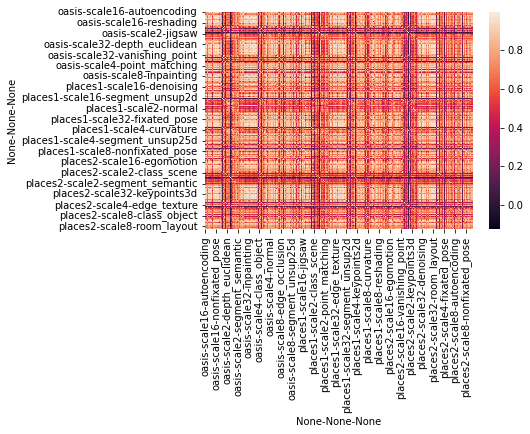

In [14]:
g = layerlayer_integration_rdms.groupby(["dataset", "scale", "model"])


parameters = g.groups.keys()
predictor_rdm_2 = pd.DataFrame(np.nan, index=parameters, columns=parameters)

for p1, p2 in combinations(parameters, 2):
    c = correlate_rdms(g.get_group(p1), g.get_group(p2))[0]
    predictor_rdm_2.loc[p1, p2], predictor_rdm_2.loc[p2, p1] = c, c
    
sns.heatmap(predictor_rdm_2)

In [17]:
predictor_rdm_2.to_hdf(
    os.path.join(PATH_RESULTS, "layer profile", "predictor2 " + _blocking + ".hd5"),
    key="predictor_rdm_2",
)

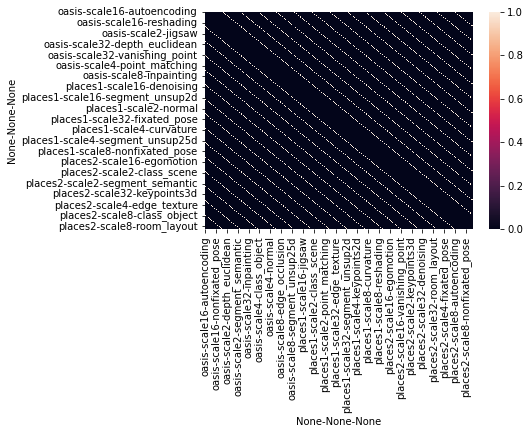

In [18]:
model_rdm_networks = pd.DataFrame(0, index=parameters, columns=parameters)

for (da1, sc1, mo1), (da2, sc2, mo2) in combinations(parameters, 2):
    if mo1 == mo2:
        model_rdm_networks.loc[(da1, sc1, mo1), (da2, sc2, mo2)] = 1
        model_rdm_networks.loc[(da2, sc2, mo2), (da1, sc1, mo1)] = 1

sns.heatmap(model_rdm_networks)

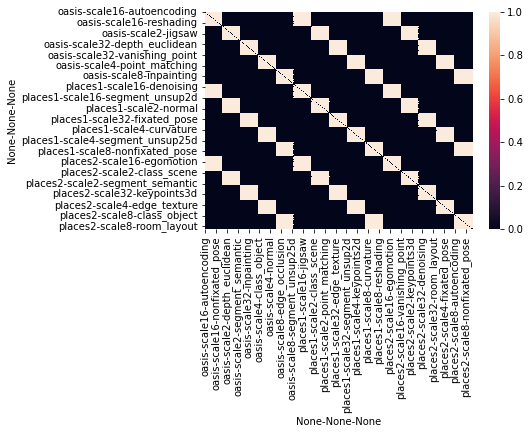

In [19]:
model_rdm_scales = pd.DataFrame(0, index=parameters, columns=parameters)

for (da1, sc1, mo1), (da2, sc2, mo2) in combinations(parameters, 2):
    if sc1 == sc2:
        model_rdm_scales.loc[(da1, sc1, mo1), (da2, sc2, mo2)] = 1
        model_rdm_scales.loc[(da2, sc2, mo2), (da1, sc1, mo1)] = 1

sns.heatmap(model_rdm_scales)

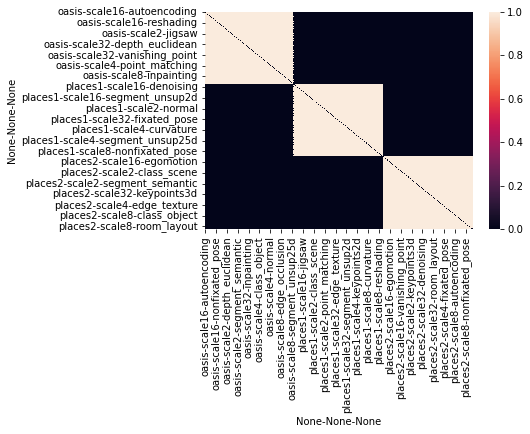

In [20]:
model_rdm_datasets = pd.DataFrame(0, index=parameters, columns=parameters)

for (da1, sc1, mo1), (da2, sc2, mo2) in combinations(parameters, 2):
    if da1 == da2:
        model_rdm_datasets.loc[(da1, sc1, mo1), (da2, sc2, mo2)] = 1
        model_rdm_datasets.loc[(da2, sc2, mo2), (da1, sc1, mo1)] = 1

sns.heatmap(model_rdm_datasets)

In [21]:
correlate_rdms(predictor_rdm_2, model_rdm_networks)

(0.13999851051400078, 2.0837638018633766e-257)

In [22]:
correlate_rdms(predictor_rdm_2, model_rdm_scales)

(0.07561375395378075, 5.679552525448072e-76)

In [23]:
correlate_rdms(predictor_rdm_2, model_rdm_datasets)

(0.008736605822776671, 0.033319200094115306)